In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy as sp
# from math import log, sqrt, exp
from abc import ABCMeta, abstractmethod
from scipy.optimize import brentq

from option_pricer import BlackScholes, Bachelier, Black76, DisplaceDiffusion, SABR

In [2]:
opt_size = (16,4.5)
orientation = (1,3)

In [3]:
spx_data = pd.read_csv('SPX_options.csv')
spx_data[spx_data['cp_flag'] == 'C']

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style
0,20201201,20201218,C,100000,3547.60,3570.50,E
1,20201201,20201218,C,200000,3447.60,3470.50,E
2,20201201,20201218,C,300000,3347.70,3370.60,E
3,20201201,20201218,C,400000,3247.70,3270.60,E
4,20201201,20201218,C,500000,3147.70,3170.60,E
...,...,...,...,...,...,...,...
1811,20201201,20210219,C,5000000,0.10,0.30,E
1812,20201201,20210219,C,5100000,0.10,0.25,E
1813,20201201,20210219,C,5200000,0.05,0.25,E
1814,20201201,20210219,C,5300000,0.10,0.20,E


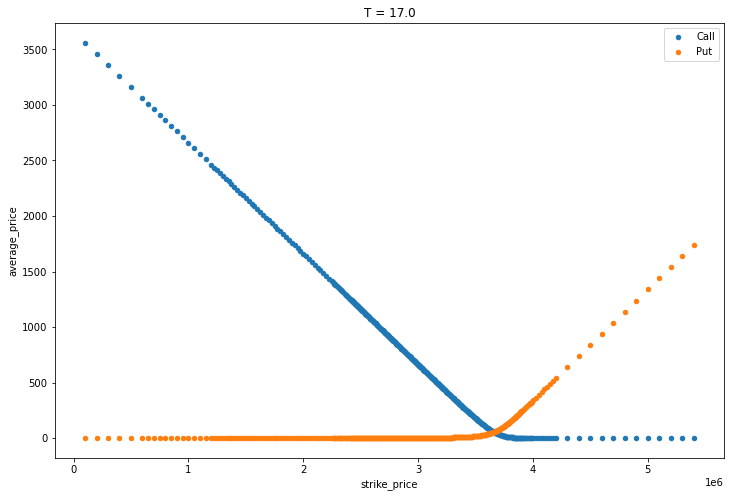

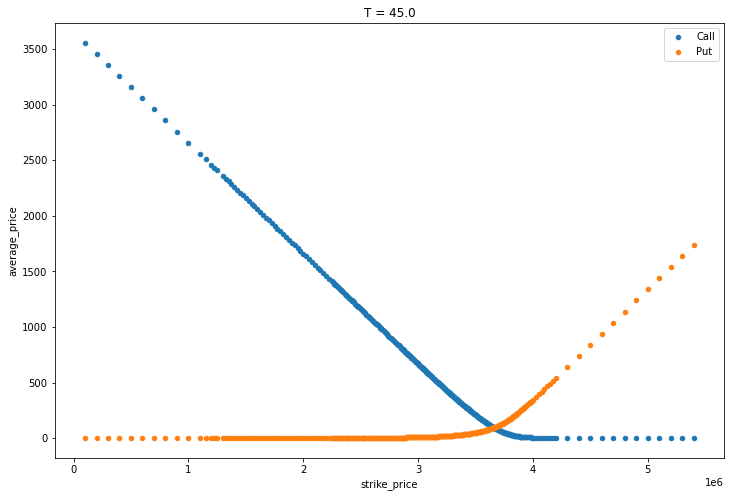

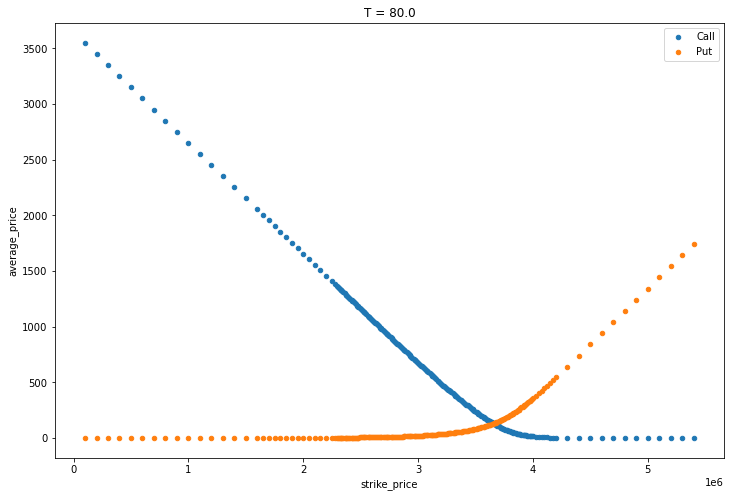

In [4]:
from matplotlib import pyplot as plt

spx_data = pd.read_csv('SPX_options.csv')

spx_data['date'] = pd.to_datetime(spx_data['date'], format='%Y%m%d')
spx_data['exdate'] = pd.to_datetime(spx_data['exdate'], format='%Y%m%d')
T_series = spx_data['exdate'] - spx_data['date']
spx_data['T'] = T_series / pd.Timedelta(1, 'D')
spx_data['average_price'] = (spx_data['best_bid'] + spx_data['best_offer'])/2
for group, df in spx_data.groupby(['T']):    
    fig, ax = plt.subplots(figsize=(12,8))
    df[df['cp_flag'] == 'C'].plot.scatter('strike_price', 'average_price', label='Call', ax=ax)
    df[df['cp_flag'] == 'P'].plot.scatter('strike_price', 'average_price', label='Put', ax=ax, color='tab:orange')
    plt.title('T = ' + str(group))
    plt.show()

In [5]:
pd.read_csv('zero_rates_20201201.csv').head()

,date,days,rate
0,20201201,7,0.102280
1,20201201,13,0.114128
2,20201201,49,0.216480
3,20201201,77,0.220707
4,20201201,104,0.219996


In [6]:
spx_price = 3662.45
zero_rates = pd.read_csv('zero_rates_20201201.csv').set_index('days')['rate']
zero_rates = zero_rates/100
rates = {}
rates[17] = (((zero_rates[49] - zero_rates[13])/(49 - 13)) * (17 - 13)) + zero_rates[13]
rates[45] = (((zero_rates[49] - zero_rates[13])/(49 - 13)) * (45 - 13)) + zero_rates[13]
rates[80] = (((zero_rates[104] - zero_rates[77])/(104 - 77)) * (80 - 77)) + zero_rates[77]

forward = {
    17: np.exp(rates[17] * 17/365) * spx_price,
    45: np.exp(rates[45] * 45/365) * spx_price,
    80: np.exp(rates[80] * 80/365) * spx_price,
}

In [7]:
forward

{17: 3662.664084743022, 45: 3663.3762493669747, 80: 3664.221472703759}

In [8]:
rates

{17: 0.0012550044444444445,
 45: 0.002051075555555556,
 80: 0.0022062799999999997}

In [9]:
spx_price = 3662.45
calibrate_df = pd.concat([spx_data['average_price'], spx_data['T'], spx_data['cp_flag'], spx_data['strike_price']/1000], axis=1)
calibrate_df['payoff'] = np.where(calibrate_df['cp_flag'] == 'C', 'call', 'put')
call_df = calibrate_df.query("strike_price > @spx_price & payoff == 'call'")
put_df = calibrate_df.query("strike_price <= @spx_price & payoff == 'put'")
calibrate_df = pd.concat([call_df, put_df]).reset_index(drop=True)
calibrate_df

,average_price,T,cp_flag,strike_price,payoff
0,52.65,17.0,C,3665.0,call
1,49.95,17.0,C,3670.0,call
2,47.25,17.0,C,3675.0,call
3,44.70,17.0,C,3680.0,call
4,42.20,17.0,C,3685.0,call
...,...,...,...,...,...
1031,119.40,80.0,P,3625.0,put
1032,121.20,80.0,P,3630.0,put
1033,124.90,80.0,P,3640.0,put
1034,128.70,80.0,P,3650.0,put


In [10]:
bs = BlackScholes(S=spx_price, verbose=False)
calibrate_df['iv'] = calibrate_df.T.apply(lambda rows: bs.implied_vol(
    price=rows.loc['average_price'],
    payoff=rows['payoff'],
    K=rows['strike_price'], 
    r=rates[int(rows['T'])],
    T=rows['T']/365,
    ))

In [11]:
calibrate_df = calibrate_df.sort_values(['T', 'strike_price'])
calibrate_df

,average_price,T,cp_flag,strike_price,payoff,iv
223,0.025,17.0,P,100.0,put,4.685324
224,0.025,17.0,P,200.0,put,3.741195
225,0.025,17.0,P,300.0,put,3.204791
226,0.025,17.0,P,400.0,put,2.830325
227,0.025,17.0,P,500.0,put,2.542973
...,...,...,...,...,...,...
218,0.200,80.0,C,5000.0,call,0.224559
219,0.175,80.0,C,5100.0,call,0.234641
220,0.150,80.0,C,5200.0,call,0.243829
221,0.150,80.0,C,5300.0,call,0.255771


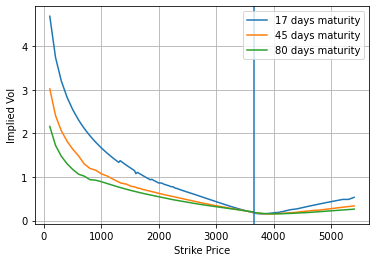

In [12]:
t17 = calibrate_df.query('T == 17')
plt.plot(t17['strike_price'], t17['iv'], label='17 days maturity')

t45 = calibrate_df.query('T == 45')
plt.plot(t45['strike_price'], t45['iv'], label='45 days maturity')

t80 = calibrate_df.query('T == 80')
plt.plot(t80['strike_price'], t80['iv'], label='80 days maturity')
plt.legend()
plt.xlabel('Strike Price')
plt.ylabel('Implied Vol')
plt.grid()
plt.axvline(spx_price)

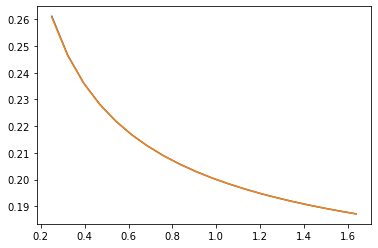

In [13]:
days = 17
A = forward[days]
S = spx_price
F = forward[days]
T = days/365
r = rates[days]

sigma_d = 0.2
beta = 0.7
K = np.linspace(F*0.25,6000,20)[:, np.newaxis]

dd = DisplaceDiffusion(F=F, r=r, sigma=sigma_d, T=T, beta=beta)
bs = BlackScholes(S=S, r=r, sigma=sigma_d, T=T)
dd_call_price = dd.vanilla_call(K=K[K>F])
dd_put_price = dd.vanilla_put(K=K[K<=F])
dd_price = np.empty_like(K)
dd_price[K>F] = dd_call_price
dd_price[K<=F] = dd_put_price

bs_reporter = BlackScholes(S=S, r=r, T=T, sigma=sigma_d)
iv_list = []
for p, k in zip(dd_price, K):
    if k < S:
        payoff = 'put'
    else:
        payoff = 'call'
        
    iv_list.append(bs_reporter.implied_vol(price=p, payoff=payoff, K=k))

plt.plot(K/F, dd.sigma_black_scholes(F, K, sigma_d, T, A, beta))
plt.plot(K/F, iv_list)

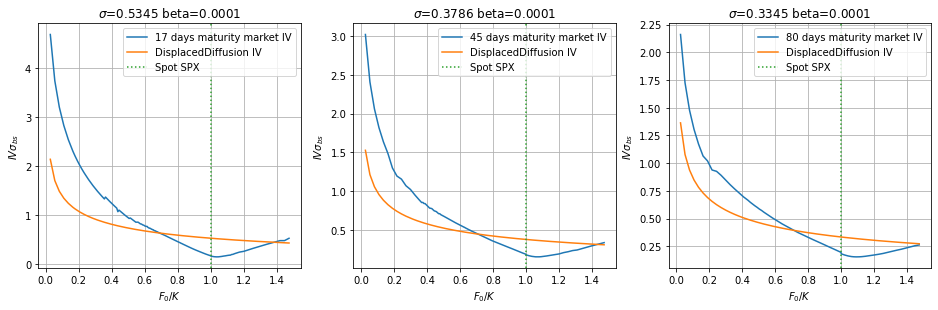

In [14]:
fig, axes = plt.subplots(orientation[0], orientation[1], figsize=opt_size)
for i, days in enumerate([17, 45, 80]):
    ax = axes[i]
    A = forward[days]
    F = forward[days]
    T = days/365

    target = calibrate_df.query('T == '+str(days))['iv'].values
    K = calibrate_df.query('T == '+str(days))['strike_price'].values

    err_f = lambda input_list: ((target - DisplaceDiffusion.sigma_black_scholes(F=F, K=K, sigma=input_list[0], T=T, A=A, beta=input_list[1])) ** 2).mean()

    opt_res = sp.optimize.minimize(err_f, [0.1, 0.2], bounds=[(0,5), (0.0001,1)])

    ax.plot(K/F, target, label=str(days) + ' days maturity market IV')
    ax.plot(K/F, DisplaceDiffusion.sigma_black_scholes(F, K, opt_res.x[0], T, A, opt_res.x[1]), label='DisplacedDiffusion IV')
    
    ax.axvline(spx_price/F, ls=':', color='tab:green', label='Spot SPX')
    ax.legend()
    ax.set_ylabel('$IV\sigma_{bs}$')
    ax.set_xlabel('$F_0/K$')
    ax.set_title('$\sigma$={:.4f} beta={:.4f}'.format(*opt_res.x))
    ax.grid()
#     opt_res

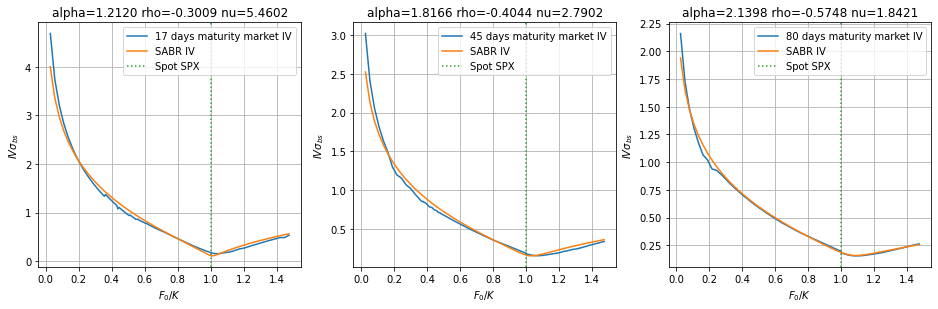

In [15]:
fig, axes = plt.subplots(orientation[0], orientation[1], figsize=opt_size)
for i, days in enumerate([17, 45, 80]):
    ax = axes[i]
    A = forward[days]
    F = forward[days]
    T = days/365
    beta=0.7

    target = calibrate_df.query('T == '+str(days))['iv'].values
    K = calibrate_df.query('T == '+str(days))['strike_price'].values

    # range_arr = K/F > 0.3
    # K = K[range_arr]
    # target = target[range_arr]

    err_f = lambda input_list: ((target 
                                 - SABR.sigma_black_scholes(F=F, 
                                                            K=K, 
                                                            T=T, 
                                                            alpha=input_list[0], 
                                                            beta=beta, 
                                                            rho=input_list[1], 
                                                            nu=input_list[2])) ** 2).mean()

    opt_res = sp.optimize.minimize(err_f, [0.02, 0.2, 0.1])

    ax.plot(K/F, target, label=str(days) + ' days maturity market IV')
    ax.plot(K/F, SABR.sigma_black_scholes(F=F, 
                                          K=K, 
                                          T=T, 
                                          alpha=opt_res.x[0], 
                                          beta=beta, 
                                          rho=opt_res.x[1], 
                                          nu=opt_res.x[2]),
            label='SABR IV')
    ax.axvline(spx_price/F, ls=':', color='tab:green', label='Spot SPX')
    ax.legend()
    ax.set_ylabel('$IV\sigma_{bs}$')
    ax.set_xlabel('$F_0/K$')
    ax.set_title('alpha={:.4f} rho={:.4f} nu={:.4f}'.format(*opt_res.x))
    ax.grid()
    opt_res

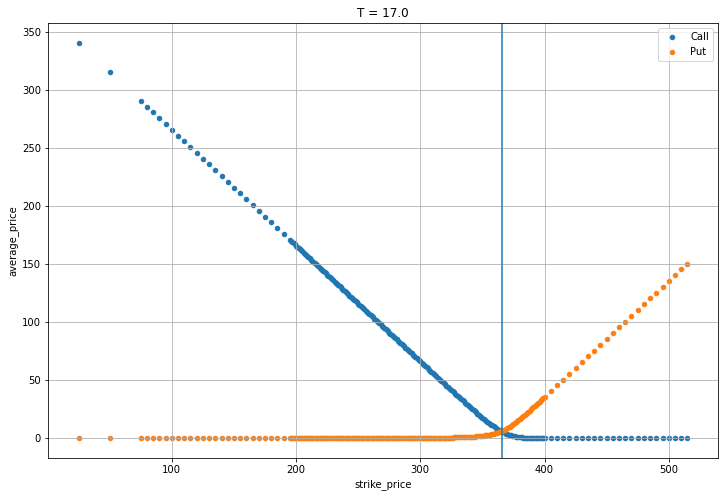

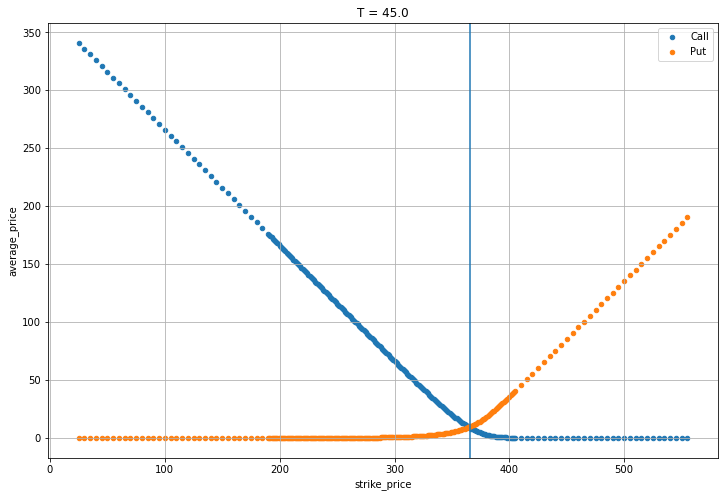

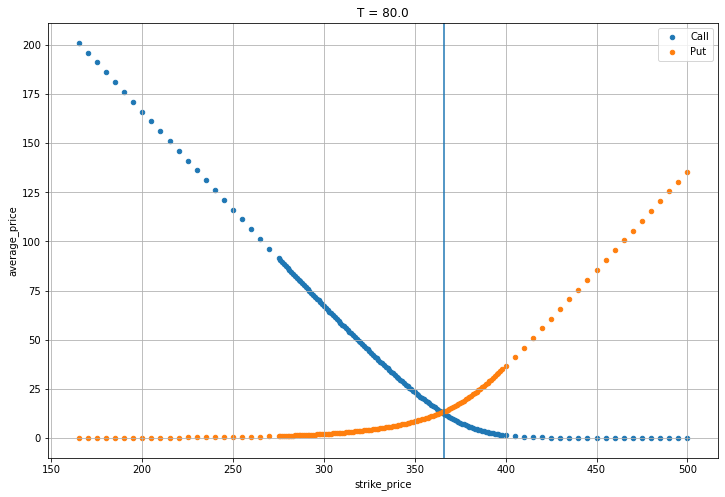

In [16]:
spy_price = 366.02
spy_data = pd.read_csv('SPY_options.csv')

spy_data['date'] = pd.to_datetime(spy_data['date'], format='%Y%m%d')
spy_data['exdate'] = pd.to_datetime(spy_data['exdate'], format='%Y%m%d')
spy_data['strike_price'] = spy_data['strike_price'] / 1000
T_series = spy_data['exdate'] - spy_data['date']
spy_data['T'] = T_series / pd.Timedelta(1, 'D')
spy_data['average_price'] = (spy_data['best_bid'] + spy_data['best_offer'])/2
for group, df in spy_data.groupby(['T']):    
    fig, ax = plt.subplots(figsize=(12,8))
    df[df['cp_flag'] == 'C'].plot.scatter('strike_price', 'average_price', label='Call', ax=ax)
    df[df['cp_flag'] == 'P'].plot.scatter('strike_price', 'average_price', label='Put', ax=ax, color='tab:orange')
    plt.title('T = ' + str(group))
    plt.axvline(spy_price)
    plt.grid()
    plt.show()
    


In [17]:
forward_spy = {
    17: np.exp(rates[17] * 17/365) * spy_price,
    45: np.exp(rates[45] * 45/365) * spy_price,
    80: np.exp(rates[80] * 80/365) * spy_price,
}

In [18]:
data = spy_data
price = spy_price
calibrate_df = pd.concat([data['average_price'], data['T'], data['cp_flag'], data['strike_price']], axis=1)
calibrate_df['payoff'] = np.where(calibrate_df['cp_flag'] == 'C', 'call', 'put')
call_df = calibrate_df.query("strike_price > @price & payoff == 'call'")
put_df = calibrate_df.query("strike_price <= @price & payoff == 'put'")
calibrate_df = pd.concat([call_df, put_df]).reset_index(drop=True).sort_values(['T', 'strike_price'])
calibrate_df

,average_price,T,cp_flag,strike_price,payoff
178,0.005,17.0,P,25.0,put
179,0.005,17.0,P,50.0,put
180,0.005,17.0,P,75.0,put
181,0.005,17.0,P,80.0,put
182,0.005,17.0,P,85.0,put
...,...,...,...,...,...
173,0.030,80.0,C,480.0,call
174,0.035,80.0,C,485.0,call
175,0.025,80.0,C,490.0,call
176,0.025,80.0,C,495.0,call


In [19]:
bs = BlackScholes(S=price, verbose=False)
calibrate_df['iv'] = calibrate_df.T.apply(lambda rows: bs.implied_vol(
    price=rows.loc['average_price'],
    payoff=rows['payoff'],
    K=rows['strike_price'], 
    r=rates[int(rows['T'])],
    T=rows['T']/365,
    ))
calibrate_df

,average_price,T,cp_flag,strike_price,payoff,iv
178,0.005,17.0,P,25.0,put,3.606730
179,0.005,17.0,P,50.0,put,2.660929
180,0.005,17.0,P,75.0,put,2.120640
181,0.005,17.0,P,80.0,put,2.035340
182,0.005,17.0,P,85.0,put,1.955363
...,...,...,...,...,...,...
173,0.030,80.0,C,480.0,call,0.205924
174,0.035,80.0,C,485.0,call,0.216124
175,0.025,80.0,C,490.0,call,0.216147
176,0.025,80.0,C,495.0,call,0.222877


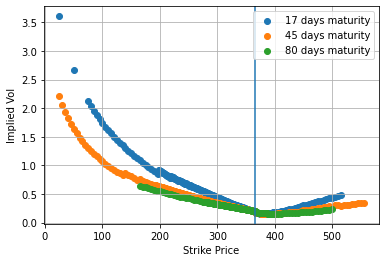

In [20]:
t17 = calibrate_df.query('T == 17')
plt.scatter(t17['strike_price'], t17['iv'], label='17 days maturity')

t45 = calibrate_df.query('T == 45')
plt.scatter(t45['strike_price'], t45['iv'], label='45 days maturity')

t80 = calibrate_df.query('T == 80')
plt.scatter(t80['strike_price'], t80['iv'], label='80 days maturity')
plt.legend()
plt.xlabel('Strike Price')
plt.ylabel('Implied Vol')
plt.grid()
plt.axvline(spy_price)

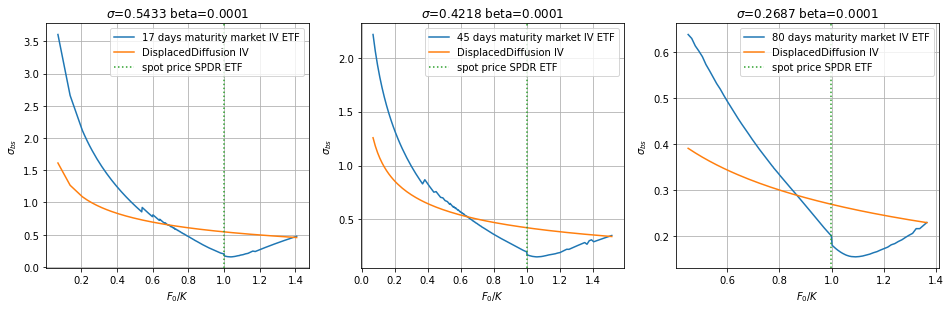

In [22]:
fig, axes = plt.subplots(orientation[0], orientation[1], figsize=opt_size)
for i, days in enumerate([17, 45, 80]):
    current_ax = axes[i]
    A = forward_spy[days]
    F = forward_spy[days]
    T = days/365
    
    spot = spy_price/F

    target = calibrate_df.query('T == '+str(days))['iv'].values
    K = calibrate_df.query('T == '+str(days))['strike_price'].values

    err_f = lambda input_list: ((target - DisplaceDiffusion.sigma_black_scholes(F=F, 
                                                                                K=K, 
                                                                                sigma=input_list[0], 
                                                                                T=T, 
                                                                                A=A, 
                                                                                beta=input_list[1])) ** 2).mean()

    opt_res = sp.optimize.minimize(err_f, [0.1, 0.2], bounds=[(0,5), (0.0001,1)])

    current_ax.plot(K/F, target, label=str(days) + ' days maturity market IV ETF')
    current_ax.plot(K/F, DisplaceDiffusion.sigma_black_scholes(F, 
                                                               K, 
                                                               opt_res.x[0], 
                                                               T, 
                                                               A, 
                                                               opt_res.x[1]), label='DisplacedDiffusion IV')
    current_ax.grid()
    current_ax.axvline(spot, ls=':', color='tab:green', label='spot price SPDR ETF')
    current_ax.set_ylabel('$\sigma_{bs}$')
    current_ax.set_xlabel('$F_0/K$')
    current_ax.set_title('$\sigma$={:.4f}'.format(opt_res.x[0]) + ' beta={:.4f}'.format(opt_res.x[1]))
    current_ax.legend()
    

C:\Users\Miti\Desktop\Stochastic\Projects\option_pricer.py:411: RuntimeWarning: invalid value encountered in sqrt
  zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))
C:\Users\Miti\Desktop\Stochastic\Projects\option_pricer.py:411: RuntimeWarning: invalid value encountered in sqrt
  zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))
C:\Users\Miti\Desktop\Stochastic\Projects\option_pricer.py:411: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))


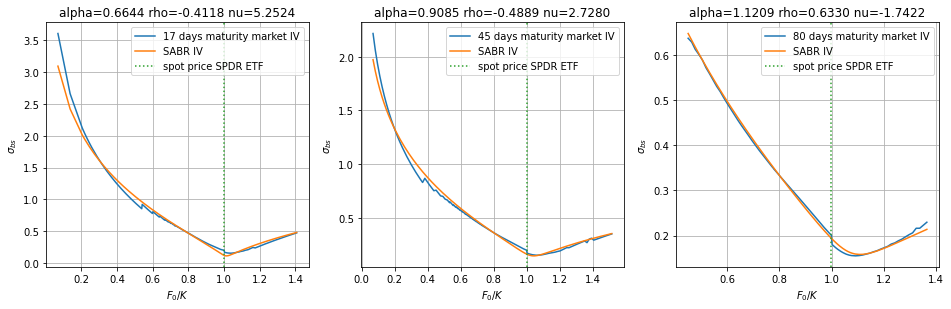

In [24]:
fig, axes = plt.subplots(orientation[0], orientation[1], figsize=opt_size)
for i, days in enumerate([17, 45, 80]):
    current_ax = axes[i]
    A = forward_spy[days]
    F = forward_spy[days]
    T = days/365

    target = calibrate_df.query('T == '+str(days))['iv'].values
    K = calibrate_df.query('T == '+str(days))['strike_price'].values

    err_f = lambda input_list: ((target 
                                 - SABR.sigma_black_scholes(F=F, 
                                                            K=K, 
                                                            T=T, 
                                                            alpha=input_list[0], 
                                                            beta=beta, 
                                                            rho=input_list[1], 
                                                            nu=input_list[2])) ** 2).mean()

    opt_res = sp.optimize.minimize(err_f, [0.02, 0.2, 0.01], bounds=[(-10,10), (-10,10), (-10,10), ])

    current_ax.plot(K/F, target, label=str(days) + ' days maturity market IV')
    current_ax.plot(K/F, SABR.sigma_black_scholes(F=F, 
                                           K=K, 
                                           T=T, 
                                           alpha=opt_res.x[0], 
                                           beta=beta, 
                                           rho=opt_res.x[1], 
                                           nu=opt_res.x[2]),
             label='SABR IV')

    current_ax.grid()
    current_ax.axvline(spot, ls=':', color='tab:green', label='spot price SPDR ETF')
    current_ax.set_ylabel('$\sigma_{bs}$')
    current_ax.set_xlabel('$F_0/K$')
    current_ax.set_title('alpha={:.4f} rho={:.4f} nu={:.4f}'.format(*opt_res.x))
    current_ax.legend()